# <center> Sentiment Analysis on Financial News Article </center>

In [ ]:
import numpy as np
import pandas as pd
import random
import string
import requests
import matplotlib.pyplot as plt
import seaborn as sns
!pip install pysentiment2
import pysentiment2 as ps
from datetime import date
from bs4 import BeautifulSoup as soup
from sklearn.feature_extraction.text import CountVectorizer
sns.set_theme()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The goal of this notebook is to perform **Sentiment Analysis** on a financial news article by using the method of text vectorization. We obtain the article from the web by scrapping using the library **BeautifulSoup**. Let's define the below function that returns a beautiful soup object of the input *URL*. This object contains all the *HTML* and *Text* information present in the webpage

In [ ]:
def get_soup_object(url):
    req = requests.get(url)
    return soup(req.content,'lxml')

The below code will retrieve all news topics in the **Yahoo Finance** news webpage [ Link: https://finance.yahoo.com/news/ ]

In [ ]:
yf_index = 'https://finance.yahoo.com/news/'
bs_main = get_soup_object(yf_index)

# News article titles are enclosed with <h3></h3> tags in the 'Main' <div> block
i = 1
for news in bs_main.find('div', id='Main').findAll('h3'):
    article = news.text
    if len(article) >= 100: article = article[:100] + '...'
    print(str(i) + ') ' + article)
    i += 1

1) Australia’s Carbon Revolution to Merge With Twin Ridge SPAC
2) Brazil's congress backs law for more crypto regulation
3) UPDATE 1-China's BYD to sell EVs in Mexico in 2023, aims for up to 30,000 sales in 2024
4) Japan considering buying up to 500 Tomahawk missiles by FY2027 -Yomiuri
5) Bitcoin Climbs to Two-Week High Ahead of Speech by Fed’s Powell
6) Stocks Seesaw in Asia Amid Focus on China, Fed: Markets Wrap
7) Asia stocks choppy as investors cautious after disappointing China data
8) GLOBAL MARKETS-Asia stocks choppy as investors cautious after disappointing China data
9) UPDATE 1-U.S. lawmakers holding talks on Boeing 737 MAX certification deadline
10) UPDATE 1-Alzheimer's drug from Eisai and Biogen slows cognitive decline, side-effects in focus


We can look at one of these topics. The below code extracts the title and text for the article from its webpage. We print the first few words from each paragraph. [ Article Link: https://finance.yahoo.com/news/apple-i-phone-demand-could-be-hammered-by-chinas-covid-situation-analyst-110120149.html ]

In [ ]:
#article_url = yf_index + 'apple-could-have-2-non-china-problems-on-its-hands-in-2023-analyst-201205949.html'
article_url = 'https://finance.yahoo.com/news/apple-i-phone-demand-could-be-hammered-by-chinas-covid-situation-analyst-110120149.html'
bs_article = get_soup_object(article_url)

title = bs_article.find('header', class_='caas-header').find('h1').text
paragraphs = bs_article.find('div', class_='caas-body').findAll('p')
paragraphs = [p.text for p in paragraphs]

print('Title: ' + title + '\n')
words, i = [], 1
for p in paragraphs:
    words.extend(p.split())
    if len(p) >= 100: p = p[:100] + '...'
    print(str(i) + ') ' + p)
    i += 1
text = ' '.join(words)

Title: Apple iPhone demand could be hammered by China's COVID situation: analyst

1) Apple's profit outlook is seeing increasing downside risk amid COVID lockdowns and protests in China...
2) "Apple is struggling to overcome a combination of shutdowns and worker protests at a key production ...
3) Darayanani added: "Since then the situation in Zhengzhou appears to have somewhat improved but not b...
4) The analyst maintained an Overweight (buy equivalent) rating on Apple stock.
5) Apple's stock rose slightly in the pre-market after an almost 3% drubbing on Monday.
6) "Protests in China against the lockdowns are growing, it’s entirely possible the situation gets wors...
7) China's COVID-19 cases are surging toward record highs just as the country was moving away from its ...
8) Daryanani isn't alone in his near-term concern on Apple's bottom line.
9) "It has been a gut punch at the worst time possible for Apple," Wedbush Managing Director Dan Ives s...
10) Ives estimated that Apple now 

The top 20 most frequently used words in the article:

In [ ]:
distinct_words, counts = np.unique(words, return_counts=True)
distinct_words, counts = [x for _, x in sorted(zip(counts, distinct_words), reverse=True)], sorted(counts, reverse=True)

for i in range(10):
    print(str(i+1) + ') ' + distinct_words[i] + ' = ' + str(counts[i]) \
          + '\t\t' + str(i+11) + ') ' + distinct_words[i+10] + ' = ' + str(counts[i+10]))

1) the = 18		11) Finance = 5
2) in = 14		12) Apple = 5
3) and = 10		13) to = 4
4) on = 9		14) that = 4
5) of = 9		15) is = 4
6) at = 6		16) are = 4
7) a = 6		17) stock = 3
8) Yahoo = 6		18) protests = 3
9) iPhone = 5		19) latest = 3
10) for = 5		20) has = 3


The top 10 words do not seem to provide any value except for the words *Yahoo* and *iPhone*. Let's plot the counts of these words

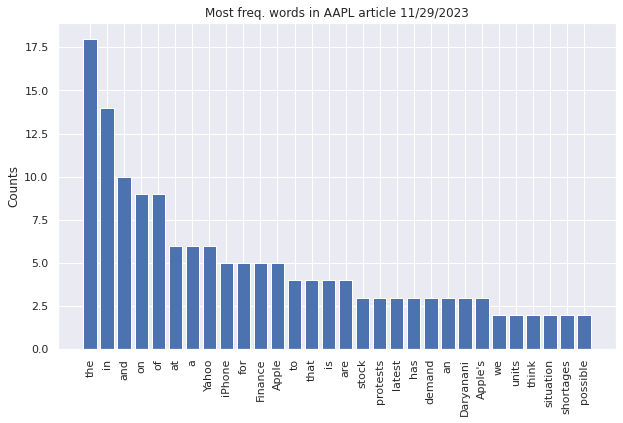

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(distinct_words[:30], counts[:30])
plt.xticks(rotation = 90)
plt.ylabel('Counts')
_ = plt.title('Most freq. words in AAPL article 11/29/2023')

The majority of the above words are function words like *the*, *in*, *of*, etc., and do not provide any value.  We can use a dictionary of such "filler-words" and remove them from the list. Furthermore, the same words with different cases are treated as different words. Let's process the words from the article before running frequency analysis

In [ ]:
filler_words = ['', 'i', 'a', 'an', 'the', 'is', 'was', 'in', 'it', 'on', 'he', 'she', 'they', 'for', 'to', 'him','her', \
                'his', 'and', 'or', 'them', 'this', 'that', 'at', 'are', 'has', 'have', 'by', 'then', 'there', 'its', \
                'from', 'here', 'as', 'said', 'will', 'most', 'very', 'isn\'t', 'it\'s', 'we', 'of']
filtered_words = [word.strip().lower().translate(str.maketrans('', '', string.punctuation)) \
                  for word in words if word not in filler_words]

In [ ]:
distinct_words, counts = np.unique(filtered_words, return_counts=True)
distinct_words, counts = [x for _, x in sorted(zip(counts, filtered_words), reverse=True)], sorted(counts, reverse=True)

for i in range(10):
    print(str(i+1) + ') ' + distinct_words[i] + ' = ' + str(counts[i]) \
          + '\t\t' + str(i+11) + ') ' + distinct_words[i+10] + ' = ' + str(counts[i+10]))

1) pre = 7		11) 60 = 3
2) units = 6		12) zero = 2
3) ives = 6		13) yahoo = 2
4) apple = 5		14) we = 2
5) zhengzhou = 4		15) toward = 2
6) moving = 4		16) time = 2
7) bottom = 4		17) somewhat = 2
8) nearly = 3		18) site = 2
9) announcing = 3		19) said = 2
10) almost = 3		20) rose = 2


After processing, the top 10 words look more interesting and contains words like *units* and *announcing*, which might be useful to analyze the sentiment.

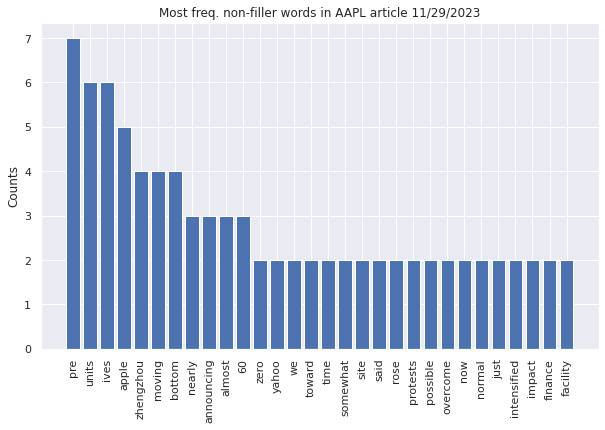

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(distinct_words[:30], counts[:30])
plt.xticks(rotation = 90)
plt.ylabel('Counts')
_ = plt.title('Most freq. non-filler words in AAPL article 11/29/2023')

Let's also look at **Bigrams** to see if they provide any interesting combination of words

In [ ]:
bigrams = [filtered_words[i-1] + '_' + filtered_words[i] for i in range(1, len(filtered_words))]

distinct_words, counts = np.unique(bigrams, return_counts=True)
distinct_words, counts = [x for _, x in sorted(zip(counts, bigrams), reverse=True)], sorted(counts, reverse=True)

for i in range(10):
    print(str(i+1) + ') ' + distinct_words[i] + ' = ' + str(counts[i]) \
          + '\t\t' + str(i+11) + ') ' + distinct_words[i+10] + ' = ' + str(counts[i+10]))

1) finance_app = 6		11) yahoo_finance = 1
2) month_to = 2		12) yahoo_finance = 1
3) finance_live = 2		13) wrote_note = 1
4) demand_could = 2		14) worst_time = 1
5) zhengzhou_china = 1		15) worse_actually = 1
6) zhengzhou_appears = 1		16) worker_protests = 1
7) zero_covid = 1		17) wipe_off = 1
8) yahoo_finance = 1		18) which_ends = 1
9) yahoo_finance = 1		19) were_talking = 1
10) yahoo_finance = 1		20) week_intensified = 1


We see word combinations like *zero_covid* and *zhengzhou_china* which might be useful for a machine learning algorithm to understand the context and sentiment in this article

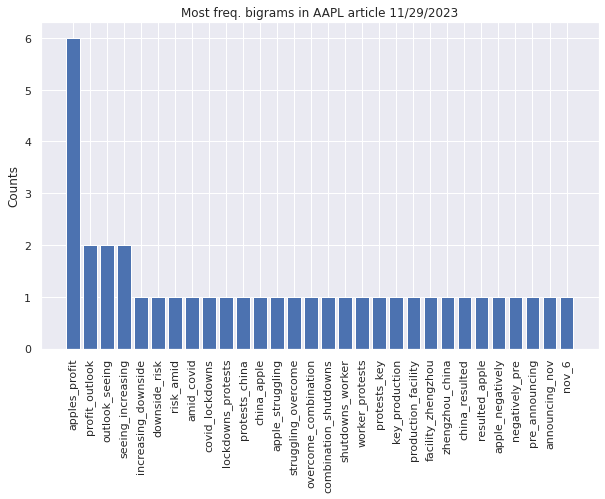

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(bigrams[:30], counts[:30])
plt.xticks(rotation = 90)
plt.ylabel('Counts')
_ = plt.title('Most freq. bigrams in AAPL article 11/29/2023')

We use the **Harvard IV4** database to calculate sentiment score for this article. We see that the algorithm has identified more negative words than positive words. It has also given an overall negative polarity score for this article, which seems to be the correct sentiment as the article talks about possible reduction in AApple's revenue.

In [ ]:
hiv4 = ps.HIV4()
tokens = hiv4.tokenize(text)
score = hiv4.get_score(tokens)
print(score)

{'Positive': 17, 'Negative': 18, 'Polarity': -0.028571427755102068, 'Subjectivity': 0.18041237020405995}


Below is the same **Harvard IV4** score analysis for each paragraph in the article

In [ ]:
i = 1
for paragraph in paragraphs[:10]:
    score = hiv4.get_score(hiv4.tokenize(paragraph))
    print(str(i) + ') ' + str(score))
    i += 1

1) {'Positive': 1, 'Negative': 1, 'Polarity': 0.0, 'Subjectivity': 0.19999998000000202}
2) {'Positive': 2, 'Negative': 3, 'Polarity': -0.199999960000008, 'Subjectivity': 0.23809522675737013}
3) {'Positive': 7, 'Negative': 2, 'Polarity': 0.5555554938271674, 'Subjectivity': 0.3333333209876548}
4) {'Positive': 1, 'Negative': 0, 'Polarity': 0.9999990000010001, 'Subjectivity': 0.1428571224489825}
5) {'Positive': 0, 'Negative': 0, 'Polarity': 0.0, 'Subjectivity': 0.0}
6) {'Positive': 2, 'Negative': 5, 'Polarity': -0.4285713673469475, 'Subjectivity': 0.3181818037190089}
7) {'Positive': 1, 'Negative': 2, 'Polarity': -0.33333322222225925, 'Subjectivity': 0.1666666574074079}
8) {'Positive': 0, 'Negative': 1, 'Polarity': -0.9999990000010001, 'Subjectivity': 0.11111109876543349}
9) {'Positive': 2, 'Negative': 3, 'Polarity': -0.199999960000008, 'Subjectivity': 0.23809522675737013}
10) {'Positive': 1, 'Negative': 1, 'Polarity': 0.0, 'Subjectivity': 0.33333327777778704}


The scores appear to be negative for most paragraphs.